# generate volume data from pointcloud

In [61]:
# virtual env: volume_rendering
! pip install vtk 
! pip install open3d
! pip install numba
! pip install scipy

## import modules

In [5]:
import sys
sys.executable

  Using cached scipy-1.8.0-cp38-cp38-win_amd64.whl (36.9 MB)


In [2]:
import os
import vtk
import time
from numba import jit
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt

## utilities

In [3]:
@jit(nopython=True, parallel=True)
def TransformPoints(T:np.array, x:np.array, y:np.array, z:np.array) -> np.array:
    # T: homogenueous transformation SE(3)
    # x, y, z: coordinates
    xyz = np.ones((4,len(x)))
    xyz[0,:] = x
    xyz[1,:] = y
    xyz[2,:] = z
    xyz_transformed = T@xyz
    return xyz_transformed

def GetExtCoeff(BScan, imgIntThresh = 45, fitWindow = 120, isVisualize = False):
    pass

## load data

In [4]:
data_folder = '../data/'
oct_data = '05-May-2022_BScan{humanAf3}.mat'
pose_data = '05-May-2022_franka_pose{humanAf3}.mat'
s = time.perf_counter()
BScan = loadmat(os.path.join(data_folder, oct_data), mat_dtype=True).get('BScan2save')
pose = loadmat(os.path.join(data_folder, pose_data), mat_dtype=True).get('pose2save')
print('loading data took:', time.perf_counter()-s, 'seconds')

loading data took: 8.364304200000003 seconds


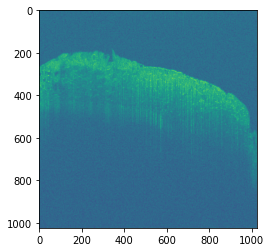

In [9]:
plt.imshow(BScan[:,:,0])

## Extract pointcloud from BScan

In [ ]:
@jit(nopython=True, parallel=True)
def genPointCloud(BScan:np.array, pose:np.array) -> np.array:
    IMG_THRESH = 55
    NUM_FRAMES = BScan.shape[-1]
    IMG_HEIGHT = BScan.shape[0]
    IMG_WIDTH = BScan.shape[1]
    LAT_RANGE = 7.8  # [mm]
    AXI_RANGE = 2.45 # [mm]
    
    pc_x = np.empty(0)
    pc_y = np.empty(0)
    pc_z = np.empty(0)
    pc_x_int = np.empty(0)
    pc_y_int = np.empty(0)
    pc_z_int = np.empty(0)

    for frm in range(NUM_FRAMES):
        frame = BScan[:,:,frm]
        T = pose[:,:,frm]
        [row, col] = np.where(frame >= IMG_THRESH)
        if len(row) and len(col):
            xlocal = np.zeros(len(row))
            ylocal = -(LAT_RANGE/IMG_WIDTH)*(col-1) + LAT_RANGE/2
            zlocal = (AXI_RANGE/IMG_HEIGHT)*(row-1)

            xint = np.zeros(len(row),dtype=np.uint8)
            yint = np.zeros(len(row),dtype=np.uint8)
            zint = np.zeros(len(row),dtype=np.uint8)
            for i, (r, c) in enumerate(zip(row, col)):
                xint[i] = frame[r, c]
                yint[i] = frame[r, c]
                zint[i] = frame[r, c]

            # TODO: compensate calibration error
            xyzglobal = TransformPoints(T, xlocal, ylocal, zlocal)
            xglobal = xyzglobal[0,:]
            yglobal = xyzglobal[1,:]
            zglobal = xyzglobal[2,:]

            pc_x = np.append(pc_x, xglobal, axis=0)
            pc_y = np.append(pc_y, yglobal, axis=0)
            pc_z = np.append(pc_z, zglobal, axis=0)
            pc_x_int = np.append(pc_x_int, xint, axis=0)
            pc_y_int = np.append(pc_y_int, yint, axis=0)
            pc_z_int = np.append(pc_z_int, zint, axis=0)
            
    return pc_x, pc_y, pc_z, pc_x_int, pc_y_int, pc_z_int

s = time.perf_counter()
pc_x, pc_y, pc_z, pc_x_int, pc_y_int, pc_z_int = genPointCloud(BScan, pose)
print('generating pointcloud took:', time.perf_counter()-s, 'seconds')

# TODO: time overhead
print(pc_x[0:10])

In [9]:
print(np.shape(BScan))


[]


## project points to voxel

In [8]:
# @jit(nopython=True, parallel=True)
def genVolume(BScan:np.array, pc_x:np.array, pc_y:np.array, pc_z:np.array, pc_intensity:np.array) -> np.array:
    volume = np.zeros(np.shape(BScan),dtype=np.uint8)
    res_x = np.floor(volume.shape[-1]/(np.amax(pc_x)-np.amin(pc_x)))
    res_y = np.floor(volume.shape[-1]/(np.amax(pc_y)-np.amin(pc_y)))
    res_z = np.floor(volume.shape[-1]/(np.amax(pc_z)-np.amin(pc_z)))
    relative_x = pc_x-np.min(pc_x)
    relative_y = pc_y-np.min(pc_y)
    relative_z = pc_z-np.min(pc_z)
    for i, (rel_x, rel_y, rel_z) in enumerate(zip(relative_x, relative_y, relative_z)):
        x_ind = np.floor(rel_z*res_z) + 1
        y_ind = np.floor(rel_y*res_y) + 1
        z_ind = np.floor(rel_x*res_x) + 1
        print(pc_intensity[i])
        volume[x_ind, y_ind, z_ind] = pc_intensity[i]
    return volume
                     
s = time.perf_counter()
vol = genVolume(BScan, pc_x, pc_y, pc_z, pc_x_int)
print('generating volume took:', time.perf_counter()-s, 'seconds')

ValueError: zero-size array to reduction operation maximum which has no identity